# Import Data and Train Model


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision.transforms import ToTensor, Lambda

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd;
import numpy as np
import math

from sklearn.model_selection import train_test_split

## Load Data: Create Dataset


### Load Absence Seizure Data


In [385]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            x_loaded.append(np.load(row["data"]))
            y_loaded.append(np.load(row["labels"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        return continuous_x, continuous_y

In [386]:
# Split Data
dataset = AbsenceDataset(
    "processed_data/absence/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)

train_set, eval_set, test_set = random_split(
    dataset, [int(len(dataset) * 0.7), int(len(dataset) * 0.2), int(len(dataset) * 0.1)]
)

In [387]:
len(dataset)

1520

In [395]:
train_dataloader = DataLoader(dataset=train_set, batch_size=5)
eval_dataloader = DataLoader(dataset=eval_set, batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

In [396]:
# # Dummy Training Loop
# n_e = 1
# samples = len(dataset)
# n_iter = math.ceil(samples / 4)

# for e in range(n_e):
#     for i, (inputs, labels) in enumerate(train_dataloader):
#         print((inputs.shape))
#         break

torch.Size([5, 5, 1000])


In [397]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self, input_size=1000, output_size=1):
        super().__init__()
        self.CNN1 = nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3)
        self.MaxPool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.CNN2 = nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3)
        self.MaxPool2 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.CNN3 = nn.Conv1d(in_channels=5, out_channels=1, kernel_size=3)
        self.MaxPool3 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.AvgPool1 = nn.AvgPool1d(kernel_size=5, stride=2)
        self.fc1 = nn.Linear(58, 1)

    def forward(self, x):
        out = self.CNN1(x)
        out = self.MaxPool1(out)
        out = self.CNN2(out)
        out = self.MaxPool2(out)
        out = self.CNN3(out)
        out = self.MaxPool3(out)
        out = self.AvgPool1(out)
        out = self.fc1(out)
        return out

In [398]:
model = AbnormalNeuralNetwork().to(device)

In [399]:
# Set optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

In [418]:
epochs = 200  # Number of training iterations
losses = []  # Append loses to this list as training goes on

for i in range(epochs):
    print(f"Epoch: {i+1}")
    for i, (x_sample, y_sample) in enumerate(train_dataloader):
        print(f"Batch: {i+1}")
        x, y = x_sample.to(device), y_sample.to(device)

        y_pred = model(x[0])
        loss = loss_function(y_pred, y)

        # Zero gradients, backward pass, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())

Epoch: 1
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Batch: 63
Batch: 64
Batch: 65
Batch: 66
Batch: 67
Batch: 68
Batch: 69
Batch: 70
Batch: 71
Batch: 72
Batch: 73
Batch: 74
Batch: 75


c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch: 76
Batch: 77
Batch: 78
Batch: 79
Batch: 80
Batch: 81
Batch: 82
Batch: 83
Batch: 84
Batch: 85
Batch: 86
Batch: 87
Batch: 88
Batch: 89
Batch: 90
Batch: 91
Batch: 92
Batch: 93
Batch: 94
Batch: 95
Batch: 96
Batch: 97
Batch: 98
Batch: 99
Batch: 100
Batch: 101
Batch: 102
Batch: 103
Batch: 104
Batch: 105
Batch: 106
Batch: 107
Batch: 108
Batch: 109
Batch: 110
Batch: 111
Batch: 112
Batch: 113
Batch: 114
Batch: 115
Batch: 116
Batch: 117
Batch: 118
Batch: 119
Batch: 120
Batch: 121
Batch: 122
Batch: 123
Batch: 124
Batch: 125
Batch: 126
Batch: 127
Batch: 128
Batch: 129
Batch: 130
Batch: 131
Batch: 132
Batch: 133
Batch: 134
Batch: 135
Batch: 136
Batch: 137
Batch: 138
Batch: 139
Batch: 140
Batch: 141
Batch: 142
Batch: 143
Batch: 144
Batch: 145
Batch: 146
Batch: 147
Batch: 148
Batch: 149
Batch: 150
Batch: 151
Batch: 152
Batch: 153
Batch: 154
Batch: 155
Batch: 156
Batch: 157
Batch: 158
Batch: 159
Batch: 160
Batch: 161
Batch: 162
Batch: 163
Batch: 164
Batch: 165
Batch: 166
Batch: 167
Batch: 168
B

c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Batch: 63
Batch: 64
Batch: 65
Batch: 66
Batch: 67
Batch: 68
Batch: 69
Batch: 70
Batch: 71
Batch: 72
Batch: 73
Batch: 74
Batch: 75
Batch: 76
Batch: 77
Batch: 78
Batch: 79
Batch: 80
Batch: 81
Batch: 82
Batch: 83
Batch: 84
Batch: 85
Batch: 86
Batch: 87
Batch: 88
Batch: 89
Batch: 90
Batch: 91
Batch: 92
Batch: 93
Batch: 94
Batch: 95
Batch: 96
Batch: 97
Batch: 98
Batch: 99
Batch: 100
Batch: 101
Batch: 102
Batch: 103
Batch: 104
Batch: 105
Batch: 106
Batch: 107
Batch: 108
Batch: 109
Batch: 110
Batch: 111
Batch: 112
Batch: 113
Batch:

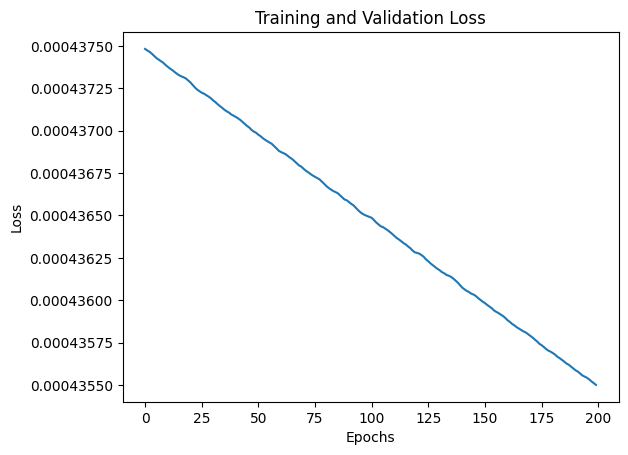

In [423]:
# Plot losses
plt.plot(range(0, epochs), losses, label="Training Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()